# Evolution

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 11

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [ ]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats2 import Cdf
from thinkstats2 import RandomSeed

import thinkplot

from matplotlib import rc
rc('animation', html='html5')

## The Fitness landscape

A genotype is represented by a length-N array of 0s and 1.

The fitness landscape maps from each location in N-D space to a random fitness.


In [ ]:
class FitnessLandscape:
    def __init__(self, N):
        """Create a fitness landscape.
        
        N: number of dimensions
        """
        self.N = N
        self.set_values()
        
    def set_values(self):
        # fitness values of having a one at a location
        self.one_values = np.random.random(self.N)
        # fitness values of having a zero at a location
        self.zero_values = np.random.random(self.N)

    def random_loc(self):
        """Choose a random location."""
        # in NumPy versions prior to 1.11, you might need
        #return np.random.randint(2, size=self.N).astype(np.int8)
        return np.random.randint(2, size=self.N, dtype=np.int8)
    
    def fitness(self, loc):
        """Evaluates the fitness of a location.
        
        loc: array of N 0s and 1s
        
        returns: float fitness
        """
        # one_values[index] if loc[index] is 0 else zero_values[index]
        fs = np.where(loc, self.one_values, self.zero_values)
        return fs.mean()
    
    def distance(self, loc1, loc2):
        return np.sum(np.logical_xor(loc1, loc2))

As an example, here's a 3-D landscape.

In [ ]:
fit_land = FitnessLandscape(3)
fit_land.N

`one_values` and `zero_values` contain the fitness contributions of having a 1 or 0 at each element of the location array.

In [4]:
fit_land.one_values, fit_land.zero_values

(array([ 0.26093715,  0.5297086 ,  0.0229665 ]),
 array([ 0.32626242,  0.0307349 ,  0.22679591]))

The fitness of a location is the mean of its fitness contributions.

In [ ]:
loc = fit_land.random_loc()
loc

In [6]:
a = np.where(loc, fit_land.one_values, fit_land.zero_values)
a, np.mean(a)

(array([ 0.26093715,  0.0307349 ,  0.22679591]), 0.17282265495749963)

`fitness` evaluates the fitness of a location.

In [7]:
loc, fit_land.fitness(loc)

(array([1, 0, 0], dtype=int8), 0.17282265495749963)

`distance` computes the number of bit flips to get from one location to another.

In [8]:
loc1 = fit_land.random_loc()
loc2 = fit_land.random_loc()
print(loc1)
print(loc2)
fit_land.distance(loc1, loc2)

[1 1 0]
[0 1 0]


1

It uses `np.logical_xor`

In [9]:
np.logical_xor(loc1, loc2)

array([ True, False, False], dtype=bool)

## The agents

Here's the class that represents agents.

In [ ]:
class Agent:
    """Represents an agent in an NK model."""
    
    def __init__(self, loc, fit_land):
        """Create an agent at the given location.
        
        loc: array of N 0s and 1s
        fit_land: reference to an fit_land
        """
        self.loc = loc
        self.fit_land = fit_land
        self.fitness = fit_land.fitness(self.loc)
        
    def copy(self):
        return Agent(self.loc, self.fit_land)

Each agent has a location, a reference to a FitnessLandscape, and a fitness.

In [11]:
loc = fit_land.random_loc()
agent = Agent(loc, fit_land)
agent.loc, agent.fitness

(array([1, 1, 1], dtype=int8), 0.27120408421284498)

## The Simulator

The `Simulator` class provides methods to run the simulations.


In [ ]:
class Simulation:
    
    def __init__(self, fit_land, agents):
        """Create the simulation:
        
        fit_land: fit_land
        num_agents: int number of agents
        agent_maker: function that makes agents
        """
        self.fit_land = fit_land
        self.agents = np.asarray(agents)
        self.instruments = []
        
    def add_instrument(self, instrument):
        """Adds an instrument to the list.
        
        instrument: Instrument object
        """
        self.instruments.append(instrument)
        
    def plot(self, index, *args, **kwargs):
        """Plot the results from the indicated instrument.
        """
        self.instruments[index].plot(*args, **kwargs)
        
    def run(self, num_steps=500):
        """Run the given number of steps.
        
        num_steps: integer
        """
        # initialize any instruments before starting
        self.update_instruments()
        
        for _ in range(num_steps):
            self.step()
        
    def step(self):
        """Simulate a time step and update the instruments.
        """
        n = len(self.agents)
        fits = self.get_fitnesses()
        
        # see who dies
        index_dead = self.choose_dead(fits)
        num_dead = len(index_dead)
        
        # replace the dead with copies of the living
        replacements = self.choose_replacements(num_dead, fits)
        self.agents[index_dead] = replacements

        # update any instruments
        self.update_instruments()
        
    def update_instruments(self):
        for instrument in self.instruments:
            instrument.update(self)
            
    def get_locs(self):
        """Returns a list of agent locations."""
        return [tuple(agent.loc) for agent in self.agents]
    
    def get_fitnesses(self):
        """Returns an array of agent fitnesses."""
        fits = [agent.fitness for agent in self.agents]
        return np.array(fits)
    
    def choose_dead(self, ps):
        """Choose which agents die in the next timestep.
        
        ps: probability of survival for each agent
        
        returns: indices of the chosen ones
        """
        n = len(self.agents)
        is_dead = np.random.random(n) < 0.1
        index_dead = np.nonzero(is_dead)[0]
        return index_dead
        
    def choose_replacements(self, n, weights):
        """Choose which agents reproduce in the next timestep.
        
        n: number of choices
        weights: array of weights
        
        returns: sequence of Agent objects
        """
        agents = np.random.choice(self.agents, size=n, replace=True)
        replacements = [agent.copy() for agent in agents]
        return replacements

We'll use a few functions to create agents.  If we want to start with identical agents:

In [ ]:
def make_identical_agents(fit_land, num_agents, agent_maker):
    """Make an array of Agents.
    
    fit_land: FitnessLandscape
    num_agents: integer
    agent_maker: class used to make Agent
    
    returns: array of Agents
    """
    loc = fit_land.random_loc()
    agents = [agent_maker(loc, fit_land) for _ in range(num_agents)]
    return np.array(agents)

Or agents at random locations:

In [ ]:
def make_random_agents(fit_land, num_agents, agent_maker):
    """Make an array of Agents.
    
    fit_land: FitnessLandscape
    num_agents: integer
    agent_maker: class used to make Agent
    
    returns: array of Agents
    """
    locs = [fit_land.random_loc() for _ in range(num_agents)]
    agents = [agent_maker(loc, fit_land) for loc in locs]
    return np.array(agents)

Or one agent at each possible location:

In [ ]:
def make_all_agents(fit_land, agent_maker):
    """Make an array of Agents.
    
    fit_land: FitnessLandscape
    agent_maker: class used to make Agent
    
    returns: array of Agents
    """
    N = fit_land.N
    xs = np.arange(2**N)
    ys = 2**np.arange(N)[::-1]    
    locs = np.bitwise_and.outer(xs, ys) > 0
    agents = [agent_maker(loc, fit_land) for loc in locs]
    return np.array(agents)

`make_all_agents` uses the outer product of `bitwise_and`, which is not the most obvious operation.  The following cells demonstrate how it works.

We want an array that contains one row for each number $0..2^{(N-1)}$, where each row contains the binary representation of that number.

With `N=4`, here are the numbers.

In [ ]:
N=4
xs = np.arange(2**N)
xs

To compute the binary representation of each number, we compute bitwise and operations with powers of two.

In [ ]:
ys = 2**np.arange(N)[::-1]
ys

The outer product puts the `xs` down the rows and the `ys` across the columns, the computes the bitwise `and` for each `(x, y)` at each intersection.

In [ ]:
np.bitwise_and.outer(xs, ys) > 0

We could convert those booleans to integers, but it's not really necessary.

Here's how `make_all_agents` works:

In [19]:
fit_land = FitnessLandscape(4)
agents = make_all_agents(fit_land, Agent)
for agent in agents:
    print(agent.loc, agent.fitness)

[False False False False] 0.559793316531
[False False False  True] 0.533429953208
[False False  True False] 0.540999399876
[False False  True  True] 0.514636036553
[False  True False False] 0.450669146471
[False  True False  True] 0.424305783148
[False  True  True False] 0.431875229816
[False  True  True  True] 0.405511866493
[ True False False False] 0.671307186454
[ True False False  True] 0.644943823131
[ True False  True False] 0.652513269799
[ True False  True  True] 0.626149906476
[ True  True False False] 0.562183016393
[ True  True False  True] 0.53581965307
[ True  True  True False] 0.543389099738
[ True  True  True  True] 0.517025736415


## The distribution of fitness

Let's create a fitness landscape and see what the distribution of fitness looks like.

In [ ]:
RandomSeed(17)
N = 8
fit_land = FitnessLandscape(N)
agents = make_all_agents(fit_land, Agent)
sim = Simulation(fit_land, agents)

`plot_fitnesses` plots the CDF of fitness across the population.

In [ ]:
def plot_fitnesses(sim):
    """Plot the CDF of fitnesses.
    
    sim: Simulation object
    """
    fits = sim.get_fitnesses()
    cdf_fitness = Cdf(fits)
    thinkplot.Cdf(cdf_fitness)
    return np.mean(fits)

Initially the distribution is approximately Gaussian, because it's the sum of 8 independent uniformly distributed variates.  See the Central Limit Theorem.

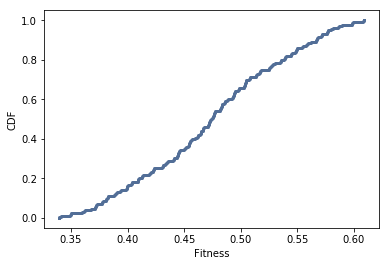

In [22]:
plot_fitnesses(sim)
thinkplot.Config(xlabel='Fitness', ylabel='CDF')

After one time step, there's not much change.

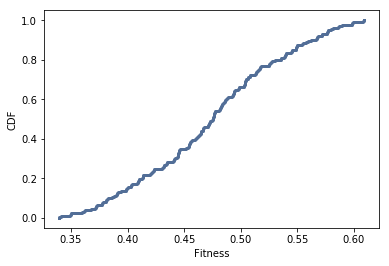

In [23]:
sim.step()
plot_fitnesses(sim)
thinkplot.Config(xlabel='Fitness', ylabel='CDF')

After 100 time steps, we can see that the number of unique values has decreased.

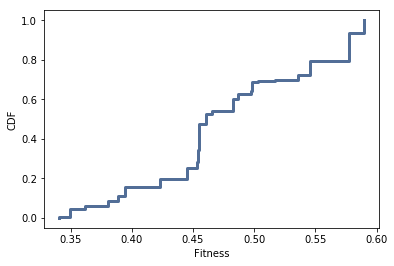

In [24]:
sim.run(100)
plot_fitnesses(sim)
thinkplot.Config(xlabel='Fitness', ylabel='CDF')

## Instruments

To measure these changes over the course of the simulations, we'll use Instrument objects.

In [ ]:
class Instrument:
    """Computes a metric at each timestep."""
    
    def __init__(self):
        self.metrics = []
        
    def update(self, sim):
        """Compute the current metric.
        
        Appends to self.metrics.
        
        sim: Simulation object
        """
        # child classes should implement this method
        pass
        
    def plot(self, **options):
        thinkplot.plot(self.metrics, **options)

The `MeanFitness` instrument computes the mean fitness after each time step.

In [ ]:
class MeanFitness(Instrument):
    """Computes mean fitness at each timestep."""
    label = 'Mean Fitness'
    
    def update(self, sim):
        mean = np.nanmean(sim.get_fitnesses())
        self.metrics.append(mean)

Here's mean fitness as a function of (simulated) time for a single run.

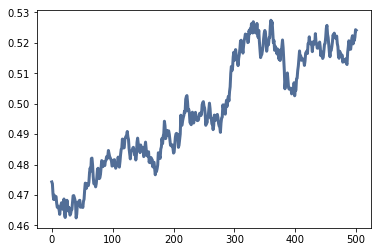

In [27]:
RandomSeed(17)
N = 8
fit_land = FitnessLandscape(N)
agents = make_all_agents(fit_land, Agent)

sim = Simulation(fit_land, agents)
instrument = MeanFitness()
sim.add_instrument(instrument)
sim.run(500)
sim.plot(0)

We can get a better sense of average behavior, and variation around the average, but plotting multiple runs.

In [ ]:
def plot_sims(fit_land, agent_maker, sim_maker, instrument_maker, **plot_options):
    """Runs simulations and plots metrics.
    
    fit_land: FitnessLandscape
    agent_maker: function that makes an array of Agents
    sim_maker: function that makes a Simulation
    instrument_maker: function that makes an instrument
    plot_options: passed along to plot
    """
    plot_options['alpha'] = 0.3

    for _ in range(10):
        agents = agent_maker(fit_land)
        sim = sim_maker(fit_land, agents)
        instrument = instrument_maker()
        sim.add_instrument(instrument)
        sim.run()
        sim.plot(0, **plot_options)
    thinkplot.Config(xlabel='Time', ylabel=instrument.label)
    return sim

`agent_maker1` puts one agent at each location.

In [ ]:
def agent_maker1(fit_land):
    return make_all_agents(fit_land, Agent)

With no differential survival or reproduction, we get a random walk.

Writing chap11-1.pdf
Writing chap11-1.png


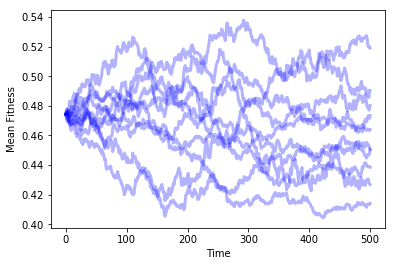

In [30]:
RandomSeed(17)
plot_sims(fit_land, agent_maker1, Simulation, MeanFitness, color='blue')
thinkplot.Save('chap11-1', clf=False)

## Differential survival

We can add differential survival by overriding `choose_dead`

In [ ]:
class SimWithDiffSurvival(Simulation):
    
    def choose_dead(self, ps):
        """Choose which agents die in the next timestep.
        
        ps: probability of survival for each agent
        
        returns: indices of the chosen ones
        """
        n = len(self.agents)
        is_dead = np.random.random(n) > ps
        index_dead = np.nonzero(is_dead)[0]
        return index_dead

With differential survival, mean fitness increases and then levels off.

Writing chap11-2.pdf
Writing chap11-2.png


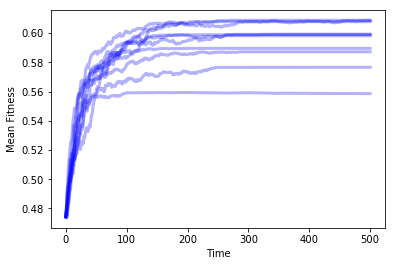

In [32]:
RandomSeed(17)
plot_sims(fit_land, agent_maker1, SimWithDiffSurvival, MeanFitness, color='blue')
thinkplot.Save('chap11-2', clf=False)

We can add differential reproduction by overriding `choose_replacements`

In [ ]:
class SimWithDiffReproduction(Simulation):

    def choose_replacements(self, n, weights):
        """Choose which agents reproduce in the next timestep.
        
        n: number of choices
        weights: array of weights
        
        returns: sequence of Agent objects
        """
        p = weights / np.sum(weights)
        agents = np.random.choice(self.agents, size=n, replace=True, p=p)
        replacements = [agent.copy() for agent in agents]
        return replacements

With differential reproduction (but not survival), mean fitness increases and then levels off.

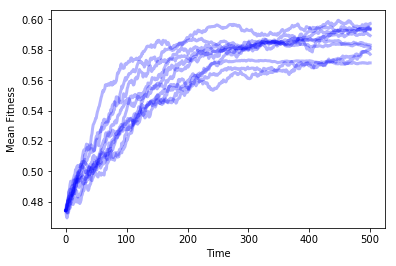

In [34]:
RandomSeed(17)
plot_sims(fit_land, agent_maker1, SimWithDiffReproduction, MeanFitness, color='blue')

**Exercise:** What if you have both?  Write a class called `SimWithBoth` that uses the new versions of `choose_dead` and `choose_replacements`.  Does mean fitness increase more quickly?

In [35]:
class SimWithDiffEverything(Simulation):
    
    def choose_replacements(self, n, fits):
        """Choose which agents reproduce in the next timestep.
        
        n: number of choices
        fits: sequence of fitnesses
        
        returns: sequence of Agent objects
        """
        p = fits / np.sum(fits)
        agents = np.random.choice(self.agents, size=n, replace=True, p=p)
        replacements = [agent.copy() for agent in agents]
        return replacements
    
    def choose_dead(self, fits):
        """Choose which agents die in the next timestep.
        
        fits: sequence of fitnesses
        
        returns: indices of the chosen ones
        """
        n = len(self.agents)
        is_dead = np.random.random(n) > fits
        index_dead = np.nonzero(is_dead)[0]
        return index_dead

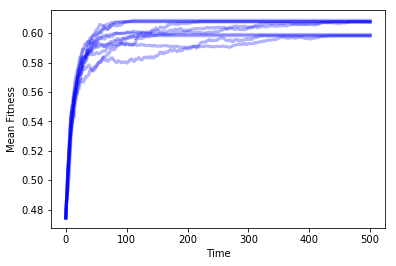

In [ ]:
RandomSeed(17)
plot_sims(fit_land, agent_maker1, SimWithDiffEverything, MeanFitness, color='blue')

## Number of different agents

Without mutation, we have no way to add diversity.  The number of occupied locations goes down over time.

`OccupiedLocations` is an instrument that counts the number of occupied locations.

In [ ]:
class OccupiedLocations(Instrument):
    label = 'Occupied Locations'

    def update(self, sim):
        uniq_agents = len(set(sim.get_locs()))
        self.metrics.append(uniq_agents)

Here's what that looks like with no differential survival or reproduction.

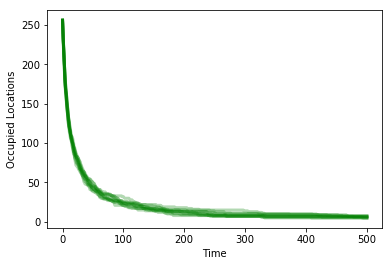

In [38]:
RandomSeed(17)
plot_sims(fit_land, agent_maker1, Simulation, OccupiedLocations, color='green')

**Exercise:** What effect do differential survival and reproduction have on the number of occupied locations?

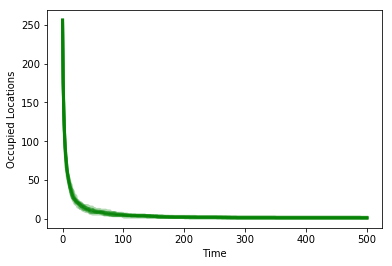

In [ ]:
RandomSeed(17)
plot_sims(fit_land, agent_maker1, SimWithDiffSurvival, OccupiedLocations, color='green')

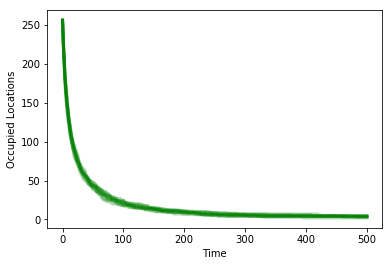

In [ ]:
RandomSeed(17)
plot_sims(fit_land, agent_maker1, SimWithDiffReproduction, OccupiedLocations, color='green')

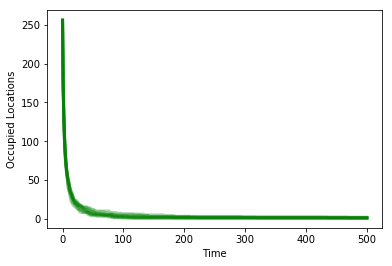

In [ ]:
RandomSeed(17)
plot_sims(fit_land, agent_maker1, SimWithDiffEverything, OccupiedLocations, color='green')

The model we have so far might explain changes in existing populations, but it doesn't explain increasing diversity or complexity.

## Mutation

Mutation is one way of increasing, or at least maintaining, diversity.

`Mutant` is a kind of agent that overrides `copy`:

In [ ]:
class Mutant(Agent):
    
    prob_mutate = 0.05
    
    def copy(self):
        if np.random.random() > self.prob_mutate:
            loc = self.loc.copy()
        else:
            direction = np.random.randint(self.fit_land.N)
            loc = self.mutate(direction)
        return Mutant(loc, self.fit_land)
    
    def mutate(self, direction):
        """Computes the location in the given direction.
        
        Result differs from the current location along the given axis.
        
        direction: int index from 0 to N-1
        
        returns: new array of N 0s and 1s
        """
        new_loc = self.loc.copy()
        new_loc[direction] ^= 1
        return new_loc

To test it out, I'll create an agent at a random location.

In [43]:
N = 8
fit_land = FitnessLandscape(N)
loc = fit_land.random_loc()
agent = Mutant(loc, fit_land)
agent.loc

array([0, 0, 0, 1, 1, 1, 0, 0], dtype=int8)

If we make 20 copies, we expect about one mutant.

In [44]:
for i in range(20):
    copy = agent.copy()
    print(fit_land.distance(agent.loc, copy.loc))

0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
1
0
0
0
0


`agent_maker2` makes identical agents.

In [ ]:
def agent_maker2(fit_land):
    agents = make_identical_agents(fit_land, 100, Mutant)
    return agents

If we start with identical mutants, we still see increasing fitness.

Writing chap11-3.pdf
Writing chap11-3.png


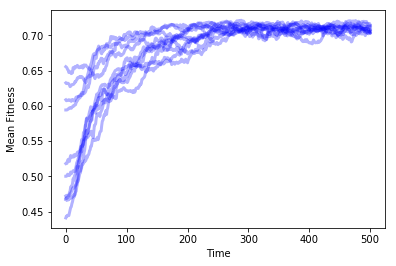

In [46]:
RandomSeed(17)
sim = plot_sims(fit_land, agent_maker2, SimWithDiffEverything, MeanFitness, color='blue')
thinkplot.Save('chap11-3', clf=False)

And now the number of occupied locations increases, reaching a steady state at about 10.

Writing chap11-4.pdf
Writing chap11-4.png


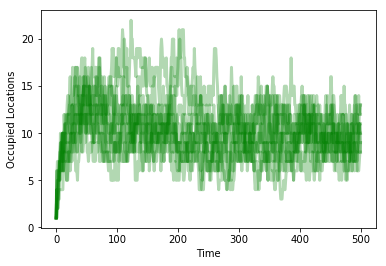

In [47]:
RandomSeed(17)
sim = plot_sims(fit_land, agent_maker2, SimWithDiffEverything, OccupiedLocations, color='green')
thinkplot.Save('chap11-4', clf=False)

In steady state, many agents are at the optimal location, and others are usually just a few mutations away.  To quantify that, we can compute the mean distance between all pairs of agents.

The distance between two agents is the number of bit flips to get from one location to another.

In [48]:
class MeanDistance(Instrument):
    """Computes mean distance between pairs at each timestep."""
    label = 'Mean Distance'
        
    def update(self, sim):
        N = sim.fit_land.N
        i1, i2 = np.triu_indices(N)
        agents = zip(sim.agents[i1], sim.agents[i2])
        
        distances = [fit_land.distance(a1.loc, a2.loc)
                     for a1, a2 in agents if a1 != a2]
        
        mean = np.mean(distances)
        self.metrics.append(mean)

Mean distance is initially 0, when all agents are identical.  It increases as the population migrates toward the optimal location, then settles into a steady state around 1.5.

Writing chap11-5.pdf
Writing chap11-5.png


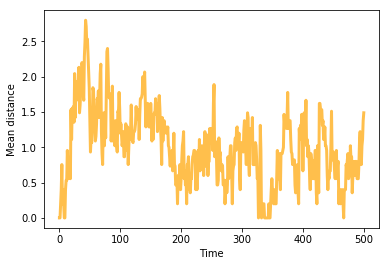

In [49]:
RandomSeed(17)

fit_land = FitnessLandscape(10)
agents = make_identical_agents(fit_land, 100, Mutant)
sim = SimWithDiffEverything(fit_land, agents)
sim.add_instrument(MeanDistance())
sim.run(500)
sim.plot(0, color='orange')
thinkplot.Config(xlabel='Time', ylabel='Mean distance')
thinkplot.Save('chap11-5', clf=False)

### Changing landscape

One cause of speciation is a change in the landscape.  Suppose a population in steady state in one landscape is transported to another landscape.  After a period of migration, it would settle around the new equilibrium point, with a small mean distance between agents.  The mean distance between the original agents and the migrants is generally much larger.

The following simulation runs 500 steps on one landscape, then switches to a different landscape and resumes the simulation.

In [50]:
RandomSeed(17)

fit_land = FitnessLandscape(10)
agents = make_identical_agents(fit_land, 100, Mutant)
sim = SimWithDiffEverything(fit_land, agents)
sim.add_instrument(MeanFitness())
sim.add_instrument(OccupiedLocations())
sim.add_instrument(MeanDistance())
sim.run(500)
locs_before = sim.get_locs()
fit_land.set_values()
sim.run(500)
locs_after = sim.get_locs()

After the switch to a new landscape, mean fitness drops briefly, then the population migrates to the new optimal location, which happens to be higher, in this example.

Writing chap11-6.pdf
Writing chap11-6.png


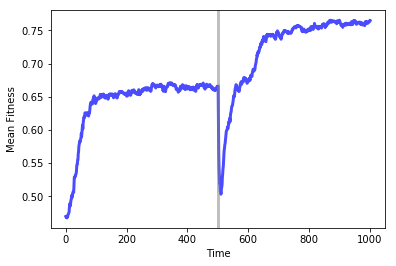

In [51]:
sim.plot(0, color='blue')
plt.axvline(500, color='gray', linewidth=3, alpha=0.5)
thinkplot.Config(xlabel='Time', ylabel='Mean Fitness')
thinkplot.Save('chap11-6', clf=False)

The number of occupied locations (sometimes) increases while the population is migrating.

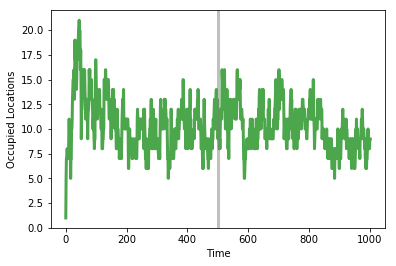

In [52]:
sim.plot(1, color='green')
plt.axvline(500, color='gray', linewidth=3, alpha=0.5)
thinkplot.Config(xlabel='Time', ylabel='Occupied Locations')

And the mean distance (sometimes) increases until the population reaches the new steady state.

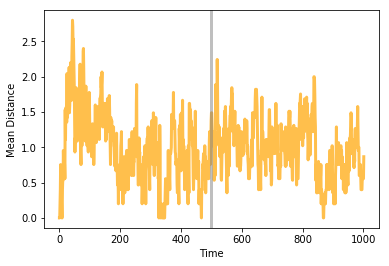

In [53]:
sim.plot(2, color='orange')
plt.axvline(500, color='gray', linewidth=3, alpha=0.5)
thinkplot.Config(xlabel='Time', ylabel='Mean Distance')

The mean distance between clusters is much bigger than the dispersion within clusters, so we can interpret the clusters as distinct species.

In [54]:
distances = []
for loc1 in locs_before:
    for loc2 in locs_after:
        distances.append(fit_land.distance(loc1, loc2))
np.mean(distances)

6.3948

**Exercise:** When we change the landscape, the number of occupied locations and the mean distance sometimes increases, but it is not always clear.  You might want to try out some different random seeds to see how general this behavior is.

In [55]:
def run_sim():
    fit_land = FitnessLandscape(10)
    agents = make_identical_agents(fit_land, 100, Mutant)
    sim = SimWithDiffEverything(fit_land, agents)
    sim.add_instrument(MeanFitness())
    sim.add_instrument(OccupiedLocations())
    sim.add_instrument(MeanDistance())
    sim.run(500)
    locs_before = sim.get_locs()
    fit_land.set_values()
    sim.run(500)
    locs_after = sim.get_locs()
    
    thinkplot.Figure(figsize=(6,4))
    sim.plot(0, color='blue')
    plt.axvline(500, color='gray', linewidth=3, alpha=0.5)
    thinkplot.Config(xlabel='Time', ylabel='Mean Fitness')

    thinkplot.Figure(figsize=(6,4))
    sim.plot(1, color='green')
    plt.axvline(500, color='gray', linewidth=3, alpha=0.5)
    thinkplot.Config(xlabel='Time', ylabel='Occupied Locations')
    
    thinkplot.Figure(figsize=(6,4))
    sim.plot(2, color='orange')
    plt.axvline(500, color='gray', linewidth=3, alpha=0.5)
    thinkplot.Config(xlabel='Time', ylabel='Mean Distance')

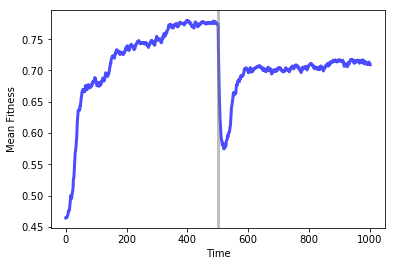

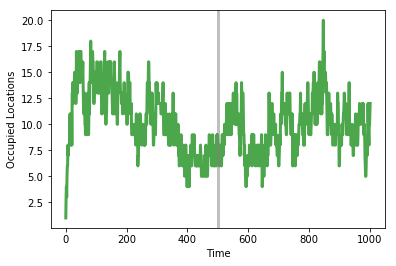

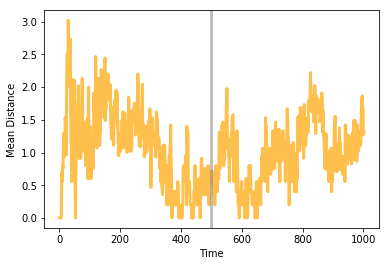

In [56]:
RandomSeed(24)

run_sim()

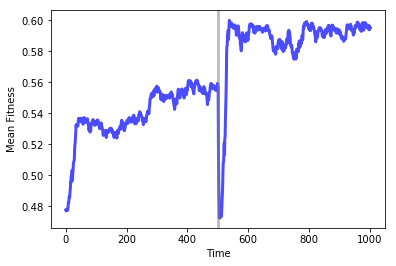

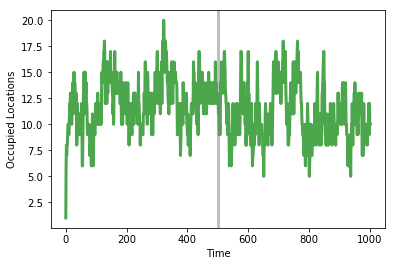

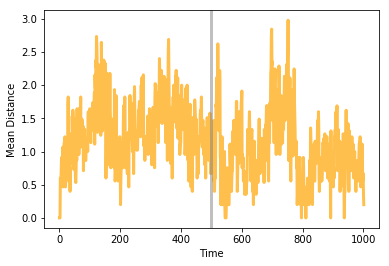

In [57]:
RandomSeed(128)

run_sim()

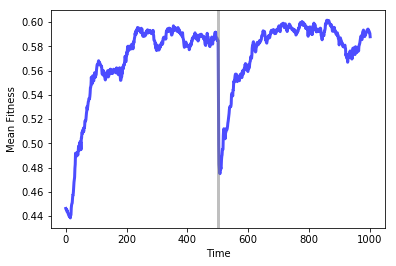

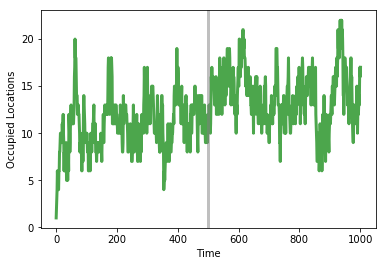

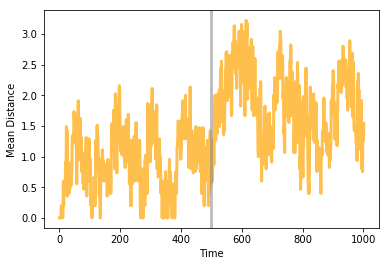

In [58]:
RandomSeed(2)

run_sim()